EJEMPLO: Procesando 'lemon_leaf'

Valores de banda WV-2:
  Coastal     : 0.0432
  Blue        : 0.0738
  Green       : 0.2306
  Yellow      : 0.2373
  Red         : 0.1678
  Red Edge    : 0.4532
  NIR1        : 0.5194
  NIR2        : 0.5301


/Users/diegomd/Desktop/git_hub/Remote_sensing_analysis/src/signatures_processing.py:56: RuntimeWarning: Mean of empty slice
  mean_refl = np.nanmean(signatures, axis=0)


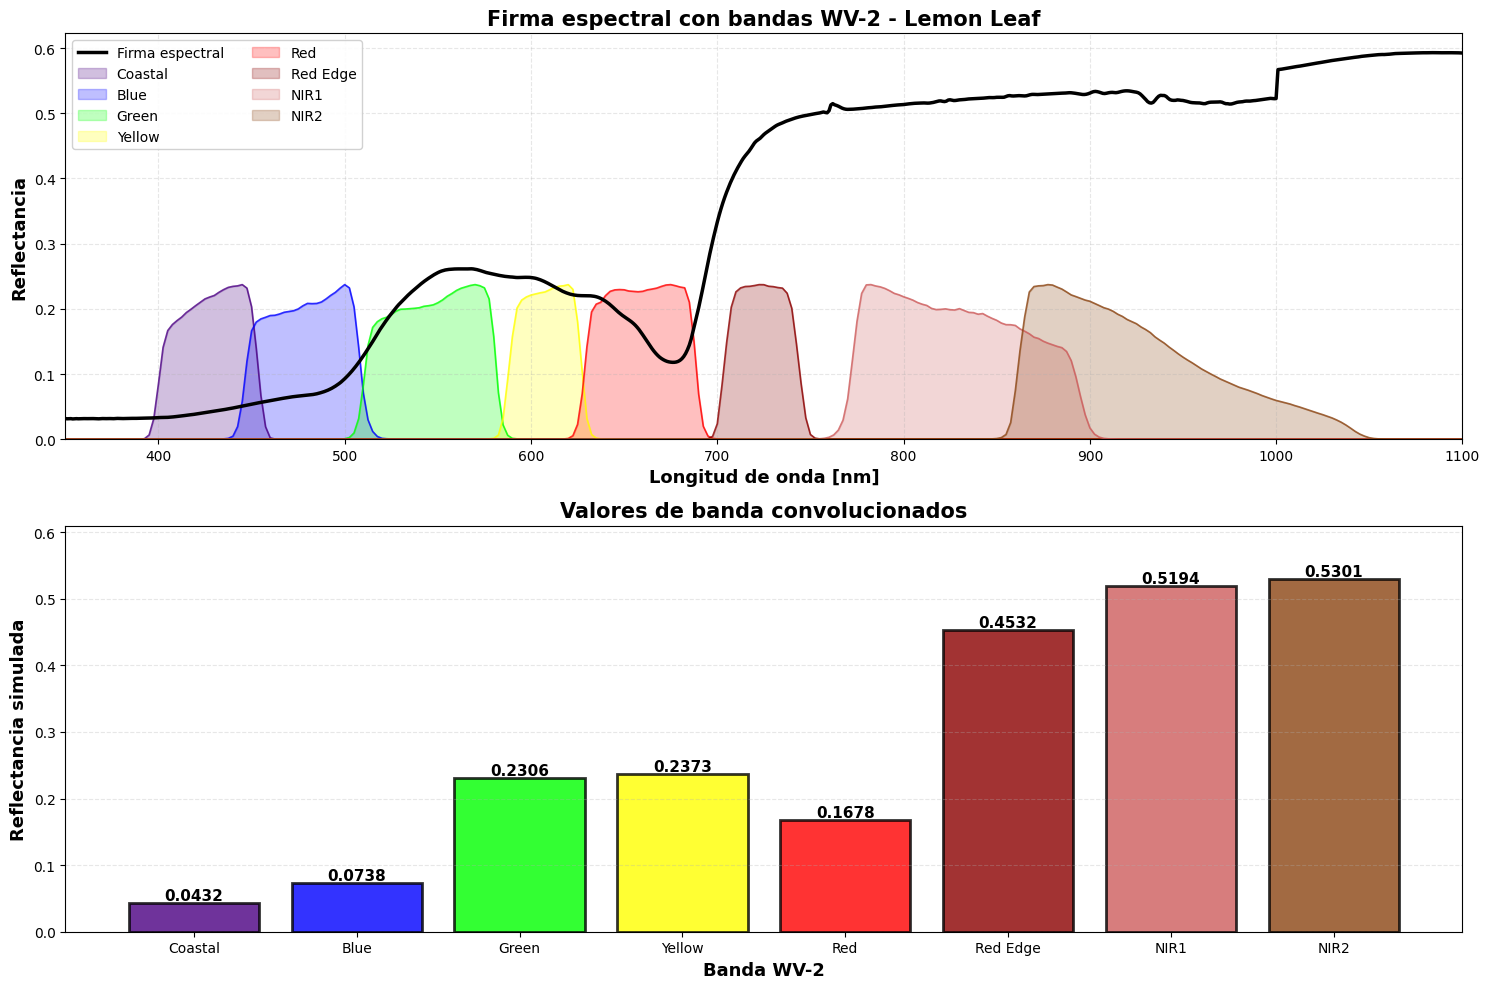

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from pathlib import Path
import pandas as pd
import sys

# Añadir el directorio raíz del proyecto al path
root_path = Path(__file__).resolve().parent.parent if '__file__' in globals() else Path('../').resolve()
if str(root_path) not in sys.path:
    sys.path.insert(0, str(root_path))


# ------------------------------------------------------
# CARGAR FUNCIONES DE RESPUESTA ESPECTRAL DE WV-2
# ------------------------------------------------------

def load_wv2_srf(file_path='../data/WV2.txt'):
    """
    Carga las Funciones de Respuesta Espectral (SRF) de WorldView-2 
    desde el archivo oficial.
    
    Returns:
        dict: {nombre_banda: {'wavelength': array, 'response': array}}
    """
    # Leer el archivo
    df = pd.read_csv(file_path, sep='\t')
    
    # Nombres de las columnas (bandas)
    band_columns = {
        'WV2 Coastal Blue': 'Coastal',
        'WV2 Blue': 'Blue', 
        'WV2 Green': 'Green',
        'WV2 Yellow': 'Yellow',
        'WV2 Red': 'Red',
        'WV2 RedEdge': 'Red Edge',
        'WV2 NIR1': 'NIR1',
        'WV2 NIR2': 'NIR2'
    }
    
    bands_srf = {}
    wavelength = df['WL(nm)'].values
    
    for col_name, band_name in band_columns.items():
        response = df[col_name].values
        
        # Calcular el centro de banda (weighted average)
        valid_mask = response > 0.01  # Solo valores significativos
        if np.any(valid_mask):
            center = np.average(wavelength[valid_mask], weights=response[valid_mask])
        else:
            center = wavelength[np.argmax(response)]
        
        bands_srf[band_name] = {
            'wavelength': wavelength,
            'response': response,
            'center': center
        }
    
    return bands_srf


# ------------------------------------------------------
# CONVOLUCIÓN: FIRMA ESPECTRAL → VALORES DE BANDA
# ------------------------------------------------------

def convolve_signature_with_band(wavelength, reflectance, band_wl, band_response):
    """
    Convoluciona una firma espectral con la función de respuesta de una banda.
    
    Formula:
        R_band = ∫ R(λ) * SRF(λ) dλ / ∫ SRF(λ) dλ
    
    Parameters:
        wavelength: array, longitudes de onda de la firma (nm)
        reflectance: array, reflectancia de la firma
        band_wl: array, longitudes de onda de la SRF de la banda
        band_response: array, valores de respuesta de la SRF (0 a 1)
    
    Returns:
        float: valor de reflectancia simulado para esa banda
    """
    # Interpolar la firma espectral a las longitudes de onda de la SRF
    # Usamos interpolación lineal y extrapolación constante
    refl_interp = interp1d(wavelength, reflectance, kind='linear', 
                           bounds_error=False, fill_value=np.nan)
    
    # Obtener reflectancia en las longitudes de onda de la SRF
    refl_at_srf = refl_interp(band_wl)
    
    # Crear máscara para valores válidos (no NaN y respuesta > umbral)
    valid_mask = (~np.isnan(refl_at_srf)) & (band_response > 1e-6)
    
    if not np.any(valid_mask):
        return np.nan
    
    # Calcular la integral ponderada usando regla del trapecio
    numerator = np.trapz(
        refl_at_srf[valid_mask] * band_response[valid_mask], 
        band_wl[valid_mask]
    )
    denominator = np.trapz(
        band_response[valid_mask], 
        band_wl[valid_mask]
    )
    
    if denominator == 0:
        return np.nan
    
    return numerator / denominator


def simulate_wv2_bands(wavelength, reflectance, bands_srf=None, srf_file='../data/WV2.txt'):
    """
    Simula los valores de reflectancia para todas las bandas de WorldView-2.
    
    Parameters:
        wavelength: array, longitudes de onda de la firma (nm)
        reflectance: array, reflectancia de la firma
        bands_srf: dict, funciones de respuesta espectral (si None, carga desde archivo)
        srf_file: str, ruta al archivo WV2.txt
    
    Returns:
        dict: {nombre_banda: valor_reflectancia}
    """
    if bands_srf is None:
        bands_srf = load_wv2_srf(srf_file)
    
    band_values = {}
    
    for band_name, band_data in bands_srf.items():
        value = convolve_signature_with_band(
            wavelength, reflectance,
            band_data['wavelength'],
            band_data['response']
        )
        band_values[band_name] = value
    
    return band_values


# ------------------------------------------------------
# VISUALIZACIÓN
# ------------------------------------------------------

def plot_signature_with_wv2_bands(wavelength, reflectance, band_values, 
                                  bands_srf=None, title="", srf_file='../data/WV2.txt'):
    """
    Grafica la firma espectral junto con las bandas de WV-2 y los valores simulados.
    """
    if bands_srf is None:
        bands_srf = load_wv2_srf(srf_file)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Panel superior: Firma espectral con SRF de las bandas
    ax1.plot(wavelength, reflectance, 'k-', linewidth=2.5, label='Firma espectral', zorder=10)
    
    # Colores para cada banda
    band_colors = {
        'Coastal': '#4B0082',
        'Blue': '#0000FF',
        'Green': '#00FF00',
        'Yellow': '#FFFF00',
        'Red': '#FF0000',
        'Red Edge': '#8B0000',
        'NIR1': '#CD5C5C',
        'NIR2': '#8B4513'
    }
    
    # Dibujar las SRF de cada banda (escaladas para visualización)
    max_refl = np.nanmax(reflectance) if not np.all(np.isnan(reflectance)) else 1.0
    
    for band_name, band_data in bands_srf.items():
        color = band_colors.get(band_name, 'gray')
        
        # Normalizar y escalar la SRF para visualización
        srf_normalized = band_data['response'] / np.max(band_data['response'])
        scaled_response = srf_normalized * max_refl * 0.4
        
        ax1.fill_between(band_data['wavelength'], 0, scaled_response, 
                        alpha=0.25, color=color, label=f"{band_name}")
        ax1.plot(band_data['wavelength'], scaled_response, 
                color=color, linewidth=1.2, alpha=0.8)
    
    ax1.set_xlabel('Longitud de onda [nm]', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Reflectancia', fontsize=13, fontweight='bold')
    ax1.set_title(f'Firma espectral con bandas WV-2 - {title}', fontsize=15, fontweight='bold')
    ax1.legend(loc='upper left', fontsize=10, ncol=2, framealpha=0.9)
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.set_xlim(350, 1100)
    ax1.set_ylim(0, max_refl * 1.05)
    
    # Panel inferior: Valores de banda simulados (gráfico de barras)
    band_names = list(band_values.keys())
    band_vals = [band_values[name] for name in band_names]
    colors = [band_colors.get(name, 'gray') for name in band_names]
    
    bars = ax2.bar(band_names, band_vals, color=colors, alpha=0.8, 
                   edgecolor='black', linewidth=2)
    
    # Añadir valores numéricos sobre las barras
    for bar, val in zip(bars, band_vals):
        height = bar.get_height()
        if not np.isnan(val):
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{val:.4f}', ha='center', va='bottom', 
                    fontsize=11, fontweight='bold')
    
    ax2.set_ylabel('Reflectancia simulada', fontsize=13, fontweight='bold')
    ax2.set_xlabel('Banda WV-2', fontsize=13, fontweight='bold')
    ax2.set_title('Valores de banda convolucionados', fontsize=15, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y', linestyle='--')
    
    max_val = np.nanmax(band_vals) if not np.all(np.isnan(band_vals)) else 1.0
    ax2.set_ylim(0, max_val * 1.15)
    
    plt.tight_layout()
    return fig


def plot_all_signatures_wv2(data_folder, categories, srf_file='../data/WV2.txt'):
    """
    Procesa y visualiza todas las firmas espectrales con sus valores WV-2.
    
    Parameters:
        data_folder: Path, carpeta con los datos de campo
        categories: dict, categorías y objetos
        srf_file: str, ruta al archivo WV2.txt
    """
    from src.signatures_processing import load_signatures_for_object
    
    # Cargar SRF una sola vez
    bands_srf = load_wv2_srf(srf_file)
    
    results = {}
    
    for category, objects in categories.items():
        print(f"\n{'='*60}")
        print(f"Categoría: {category.upper()}")
        print(f"{'='*60}")
        
        for obj in objects:
            # Cargar firma espectral
            wl, refl = load_signatures_for_object(data_folder, obj, clean=True)
            
            if wl is not None and refl is not None:
                # Simular bandas WV-2
                band_values = simulate_wv2_bands(wl, refl, bands_srf)
                
                # Guardar resultados
                results[obj] = band_values
                
                # Mostrar valores
                print(f"\n{obj}:")
                for band, value in band_values.items():
                    print(f"  {band:12s}: {value:.4f}")
                
                # Visualizar
                plot_signature_with_wv2_bands(wl, refl, band_values, bands_srf, 
                                             title=obj.replace('_', ' ').title())
                plt.show()
    
    return results


def export_band_values(band_values_dict, output_file):
    """
    Exporta los valores de banda de múltiples objetos a un archivo CSV.
    
    Parameters:
        band_values_dict: dict, {objeto: {banda: valor}}
        output_file: str o Path, archivo de salida
    """
    df = pd.DataFrame(band_values_dict).T
    df.index.name = 'Object'
    df.to_csv(output_file)
    print(f"✓ Valores de banda exportados a: {output_file}")


def create_spectral_library(data_folder, categories, output_csv, srf_file='../data/WV2.txt'):
    """
    Crea una biblioteca espectral completa con valores de banda WV-2 
    para todos los objetos.
    
    Parameters:
        data_folder: Path, carpeta con datos de campo
        categories: dict, categorías y objetos
        output_csv: str, archivo CSV de salida
        srf_file: str, archivo con SRF de WV-2
    
    Returns:
        DataFrame con valores de banda para todos los objetos
    """
    from src.signatures_processing import load_signatures_for_object
    
    bands_srf = load_wv2_srf(srf_file)
    results = {}
    
    print("Creando biblioteca espectral WV-2...")
    
    for category, objects in categories.items():
        for obj in objects:
            wl, refl = load_signatures_for_object(data_folder, obj, clean=True)
            
            if wl is not None and refl is not None:
                band_values = simulate_wv2_bands(wl, refl, bands_srf)
                results[obj] = band_values
                print(f"  ✓ {obj}")
    
    # Crear DataFrame
    df = pd.DataFrame(results).T
    df.index.name = 'Object'
    
    # Añadir columna de categoría
    category_map = {}
    for cat, objs in categories.items():
        for obj in objs:
            category_map[obj] = cat
    
    df.insert(0, 'Category', df.index.map(category_map))
    
    # Guardar
    df.to_csv(output_csv)
    print(f"\n✓ Biblioteca espectral guardada en: {output_csv}")
    print(f"  Objetos procesados: {len(df)}")
    print(f"  Bandas: {len(df.columns) - 1}")
    
    return df


# ------------------------------------------------------
# EJEMPLO DE USO
# ------------------------------------------------------

if __name__ == "__main__":
    from src.signatures_processing import load_signatures_for_object
    
    # Rutas
    data_folder = Path('../data/field')
    srf_file = '../data/WV2.txt'
    
    # Definir categorías
    categories = {
        'surfaces': ['black_asphalt', 'blue_paint', 'wood_table', 'concrete'],
        'soils': ['soil', 'dry_grass', 'rough_soil'],
        'vegetation': ['lemon_leaf', 'red_flower', 'rosemary', 'jatropha', 
                      'small_flower', 'weed', 'grass']
    }
    
    # OPCIÓN 1: Procesar un objeto específico
    print("=" * 60)
    print("EJEMPLO: Procesando 'lemon_leaf'")
    print("=" * 60)
    
    wl, refl = load_signatures_for_object(data_folder, 'lemon_leaf', clean=True)
    
    if wl is not None:
        # Simular bandas WV-2
        band_values = simulate_wv2_bands(wl, refl, srf_file=srf_file)
        
        # Mostrar valores
        print("\nValores de banda WV-2:")
        for band, value in band_values.items():
            print(f"  {band:12s}: {value:.4f}")
        
        # Visualizar
        plot_signature_with_wv2_bands(wl, refl, band_values, 
                                     title="Lemon Leaf", srf_file=srf_file)
        plt.show()
    
    # OPCIÓN 2: Crear biblioteca espectral completa
    # library_df = create_spectral_library(
    #     data_folder, 
    #     categories, 
    #     'spectral_library_wv2.csv',
    #     srf_file
    # )
    # print("\nBiblioteca espectral:")
    # print(library_df)
    
    # OPCIÓN 3: Procesar todas las firmas con visualización
    # results = plot_all_signatures_wv2(data_folder, categories, srf_file)